# Identifying Noise Source EMI Fix

Our noise source spectra show large, broadband EMI features that vary while the telescope is rotating, and remain static otherwise. Below, I show some spectra from the field, as well as lab tests that show the same features. They disappear when the SMA connectors are fully tightened - we discovered that those connectors were not all tightly screwed in, and likely became loose because of vibrations. We will need a solution for keeping these tightly connected.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import eigsep_observing as obs
import os
import csv
from datetime import datetime
%matplotlib notebook

modeR = lambda x: np.log10(np.abs(x))

DATADIR = './july2025_corrdata/'
DATE_THRESH = 1735689600

In [29]:
#Pulling data
times = []
bad_files = []
mariposa_data = []
corr02_data = []
for i in sorted(os.listdir(DATADIR)):
    filename = os.path.join(DATADIR, i)
    if 'h5' not in filename:
        continue
    try:
        data, header, metadata = obs.io.read_hdf5(filename)
    except OSError:
        print('bad file')
        bad_files.append(filename)
        continue
    times.append(header['times'])
    mariposa = data['2']
    corr02 = data['02']
    mariposa_data.append(mariposa)
    corr02_data.append(corr02)
    freqs = header['freqs']
    
#anything that has like, normal times
times = np.concatenate(times)
valid_times = times> DATE_THRESH
times = times[valid_times]
mariposa_data = np.concatenate(mariposa_data)

every16 = np.array([True] * len(freqs))
every16[::16] = False
freqs = np.array(freqs)
test = mariposa_data[valid_times][34500:74800]

bad file


In [37]:
#filtering data
ch = 345
test_range = times[34500:74800]
test_range_data = mariposa_data[valid_times][34500:74800, ch]

s11power = test_range_data > 1e7
s11power_ext = [False] * len(s11power)
for i in range(len(s11power)):
    if s11power[i]:
        for i in range(i-70, i+70):
            s11power_ext[i] = True
            i += 70
s11power_ext = np.array(s11power_ext)

not_zero = test_range_data != 0

weird_dip = [True] * len(test_range)
weird_dip[32717:32798] = [False] * (32798 - 32717) #decent
weird_dip = np.array(weird_dip)

surgeried = (s11power_ext==False) * weird_dip

b = [False] * len(test_range)
b[7398:10971] = [True] * (10971-7398)
b = np.array(b)
b_uplow = (test_range_data < 10**4.86) + (test_range_data > 10**5.76)
b *= b_uplow

d = [False] * len(test_range)
d[24697:24811] = [True] * (24811-24697) 
d = np.array(d)
d_uplow = (test_range_data < 10**4.84) + (test_range_data > 10**5.72)
d *= d_uplow

tests = mariposa_data[valid_times][38624:39433:70, every16][-2]

<IPython.core.display.Javascript object>


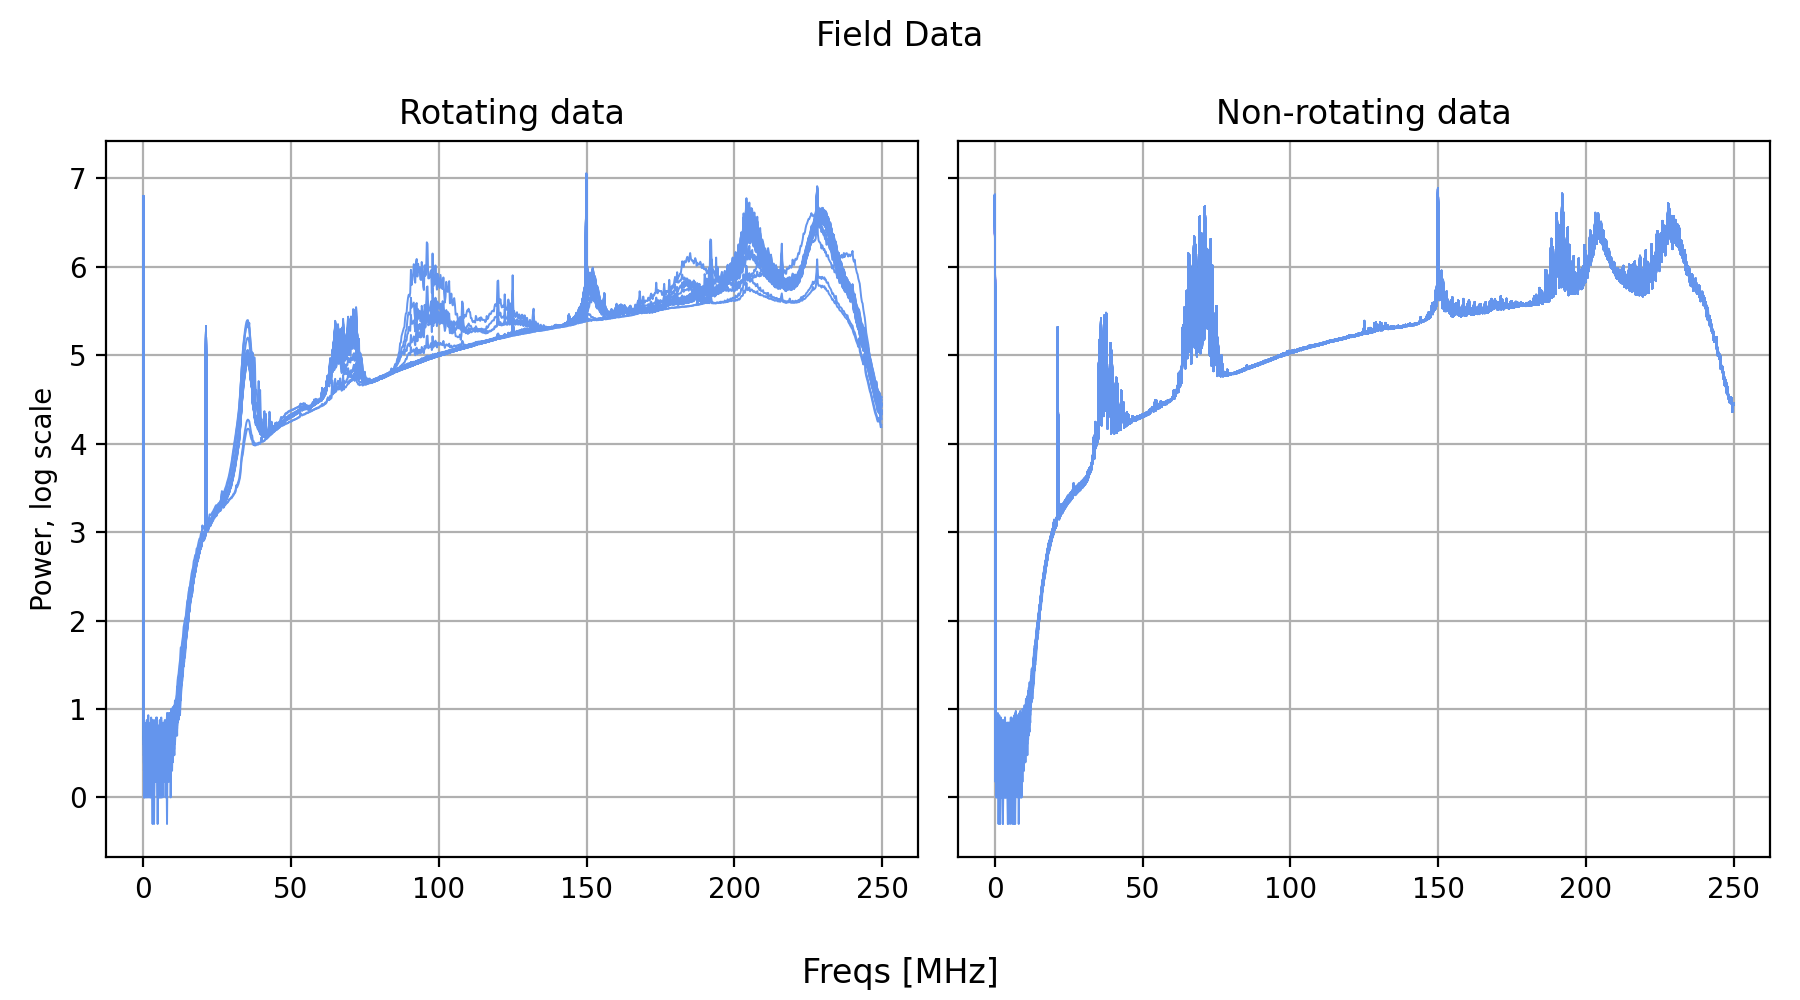

/var/folders/cy/tyk8jd852vb0cz42dfbv8tvr0000gn/T/ipykernel_17340/3180345270.py:9: RuntimeWarning: divide by zero encountered in log10
  modeR = lambda x: np.log10(np.abs(x))


In [46]:
#Field data
fig, (axes) = plt.subplots(ncols=2, figsize=(9,5), sharex = True, sharey=True)

axes[1].plot(freqs, modeR(test[surgeried * (b) * (test_range_data < 10**5)]).T, color='cornflowerblue', linewidth=0.7)
axes[1].grid()
start = datetime.fromtimestamp(test_range[(b)][0])
stop = datetime.fromtimestamp(test_range[(b)][-1])
axes[1].set_title('Non-rotating data')

axes[0].plot(freqs, modeR(test[surgeried * d * (test_range_data < 10**5)]).T, color='cornflowerblue', linewidth=0.7)
axes[0].grid()
start = datetime.fromtimestamp(test_range[d][0])
stop = datetime.fromtimestamp(test_range[d][-1])
axes[0].set_title('Rotating data')
axes[0].set_ylabel('Power, log scale')

fig.supxlabel('Freqs [MHz]')
fig.suptitle('Field Data')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


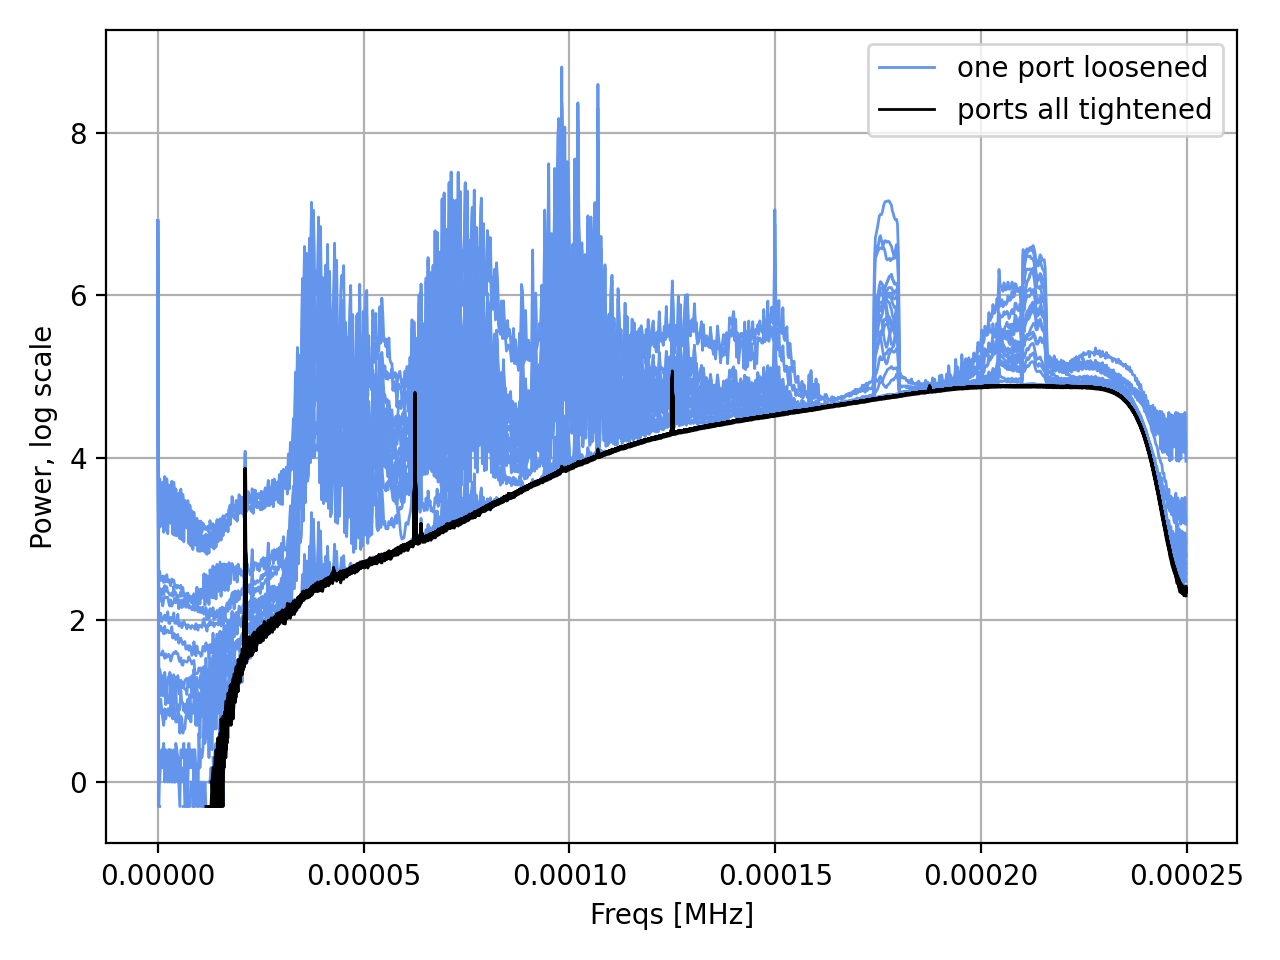

/var/folders/cy/tyk8jd852vb0cz42dfbv8tvr0000gn/T/ipykernel_17340/3180345270.py:9: RuntimeWarning: divide by zero encountered in log10
  modeR = lambda x: np.log10(np.abs(x))


In [47]:
#Lab Tests
tight_wiggling = np.load('./emi_testing_1015/wiggling_tight_port.npz')['1'][:, 0, :]
loose_wiggling = np.load('./emi_testing_1015/wiggling_loose_port.npz')['1'][:, 0, :]

plt.figure()
plt.plot(freqs/1e6, modeR(loose_wiggling).T, color='cornflowerblue', label='one port loosened', linewidth=1)
plt.plot(freqs/1e6, modeR(tight_wiggling).T, color='black', label='ports all tightened', linewidth=1)

new_label_dict = {}
handles, labels = plt.gca().get_legend_handles_labels()
for handles, labels in zip(handles, labels):
    new_label_dict[labels] = handles

plt.legend(list(new_label_dict.values()), list(new_label_dict.keys()))
plt.xlabel('Freqs [MHz]')
plt.ylabel('Power, log scale')
plt.grid()
plt.tight_layout()
plt.show()